In [1]:
### IMPORTS
from dateroll import ddh
import sys; # for localtesting
sys.path.insert(0,'/home/disent/github/ratecurve') 
from ratecurve import Curve
from ratecurve.equations import disc_factor
import matplotlib.pyplot as plt


In [2]:
### GENERATE DATA
def generate_curve_data(curve, tenors_to_interpolate, forward_tenor,verbose = False):
    anchor_date = curve.base
    dates_to_interpolate = [anchor_date +ddh(x) for x in tenors_to_interpolate]

    # Result variable instantiation
    spot_x = {} #{num:(date,tenor)}
    spot_y = {}
    
    forward_x = {}
    forward_y = {}

    report_string=''
    report_string+='-------------PAR DATA----------------\n'
    get_t = lambda b: (ddh(f't+{b}')-ddh('t')).yf("ALL","ACT/365")
    par_tenors =  [ddh(x).to_string() for x in curve.raw_data.keys()]
    par_dates = [(anchor_date+ddh(x)).to_string() for x in par_tenors]
    par_rates = list(curve.raw_data.values())
    par_dfs = [disc_factor(par_rates[i],get_t(par_tenors[i]),method="EXP") for i in range(len(par_tenors))]
    par_x_data = {curve.make_date_a_number(par_dates[i]):(par_dates[i],par_tenors[i]) for i in range(len(par_dates))}
    par_y_data = {curve.make_date_a_number(par_dates[i]):(par_rates[i],par_dfs[i]) for i in range(len(par_dates))}
    for i in range(len(par_dates)):
        report_string+=f'Tenor:{par_tenors[i]}, Par:{par_rates[i]}\n'

    report_string+='\n\n------------SPOT INTERPOLATION START------------\n'
    for i in range(len(dates_to_interpolate)):
        spot_rate = curve.spot(dates_to_interpolate[i])
        spot_df = curve(dates_to_interpolate[i])
        #x values        
        spot_x[curve.make_date_a_number(dates_to_interpolate[i])] = (dates_to_interpolate[i].to_string(),(dates_to_interpolate[i]-anchor_date).to_string())
        #y values
        spot_y[curve.make_date_a_number(dates_to_interpolate[i])] = (spot_rate, spot_df)
        report_string +=f'Tenor:{tenors_to_interpolate[i]}, Spot:{spot_rate}\n'
    report_string +='------------SPOT INTERPOLATION FINISH-----------\n\n'

    report_string+=f'-----------{forward_tenor} FORWARD INTERPOLATION START --------------\n'
    for i in range(len(dates_to_interpolate)-1):
        fwd_date = ddh(dates_to_interpolate[i]) + ddh(forward_tenor)
        fwd_rate = curve.fwd(dates_to_interpolate[i],fwd_date)
        fwd_df = disc_factor(fwd_rate, get_t(tenors_to_interpolate[i]), method= "EXP")
        #y values
        forward_y[curve.make_date_a_number(dates_to_interpolate[i])] = (fwd_rate,fwd_df)
        #x vlaues
        forward_x[curve.make_date_a_number(dates_to_interpolate[i])] = (dates_to_interpolate[i].to_string(),(dates_to_interpolate[i]-anchor_date).to_string())        
        
        report_string+=f'Tenors:({tenors_to_interpolate[i]},{tenors_to_interpolate[i]}+{forward_tenor}), Rate:{fwd_rate}\n'
    
    report_string+=f'-----------{forward_tenor} FORWARD INTERPOLATION FINISH--------------'    
    if verbose:
        print(report_string)
    par_data = {"x":par_x_data,"y":par_y_data} #"x":{"actual_x":(datelabel, tenorlabel)} "y":{"acutal_x":(rate,df)}
    spot_data = {"x":spot_x, "y": spot_y}
    forward_data = {"x":forward_x, "y": forward_y}
    return par_data, spot_data, forward_data


In [3]:
# PLOTTING FUNCTION
def plot_curve(plot_data, forward_tenor = '3m', style='line', spacing = 'actual', y_axis = 'rate', x_axis = 'tenor', to_plot = ['par','spot','forward'], plot_data_boundary = True):
    ACTUAL_SPACING_SEPERATION = 365  # Minimum amount of spacing between labels
    
    par_data = plot_data["par"]    
    spot_data = plot_data["spot"]
    forward_data = plot_data["forward"]      
    # x_vals
    #even spacing calculation
    # this scales x_vals so that all days are evenly spaced
    # 1. Find all unique x_vals (integer days since root date of curve class)
    # 2. Sort them and map unique values to their sorted index
    unique_xs = sorted(list(set(list(par_data['x'].keys())+list(spot_data['x'].keys()) + list(forward_data['x'].keys()))))
    even_x_spacing_map = {unique_xs[i]:i for i in range(len(unique_xs))}
    even_to_original_map = {v:k for k,v in even_x_spacing_map.items()}

    # Plot generation    
    fig,ax = plt.subplots()

    if 'par' in to_plot:
        raw_par_x = sorted(list(par_data["x"].keys()))
        if spacing == 'actual':
            par_x = raw_par_x
        elif spacing == 'equal':
            par_x = [even_x_spacing_map[x] for x in par_data["x"].keys()]
        
        if y_axis == 'rate':
            par_y = [par_data["y"][x][0] for x in raw_par_x]
        elif y_axis == 'df' or y_axis =='discount_factor':
            par_y = [par_data["y"][x][1] for x in raw_par_x]

        if style=='line':
            ax.plot(par_x, par_y, label="Par",)
        elif style=='scatter':
            ax.scatter(par_x, par_y, label="Par",)
        
    if 'spot' in to_plot:
        raw_spot_x = sorted(list(spot_data["x"].keys()))
        if spacing == 'actual':
            spot_x = raw_spot_x
        elif spacing == 'equal':
            spot_x = [even_x_spacing_map[x] for x in spot_data["x"].keys()]
        
        if y_axis == 'rate':
            spot_y = [spot_data["y"][x][0] for x in raw_spot_x]
        elif y_axis == 'df' or y_axis =='discount_factor':
            spot_y = [spot_data["y"][x][1] for x in raw_spot_x]

        if style=='line':
            ax.plot(spot_x, spot_y, label="Spot",)
        elif style=='scatter':
            ax.scatter(spot_x, spot_y, label="Spot",)

    if 'forward' in to_plot:
        raw_forward_x = sorted(list(forward_data["x"].keys()))
        if spacing == 'actual':
            forward_x = raw_forward_x
        elif spacing == 'equal':
            forward_x = [even_x_spacing_map[x] for x in forward_data["x"].keys()]
        
        if y_axis == 'rate':
            forward_y = [forward_data["y"][x][0] for x in raw_forward_x]
        elif y_axis == 'df' or y_axis =='discount_factor':
            forward_y = [forward_data["y"][x][1] for x in raw_forward_x]

        if style=='line':
            ax.plot(forward_x, forward_y, label=f"{forward_tenor} Forward")
        elif style=='scatter':
            ax.scatter(forward_x, forward_y, label=f"{forward_tenor} Forward")
    
    # For plotting extrapolation boundaries
    if plot_data_boundary and 'par' in to_plot:
        first_x = min(par_x)
        last_x = max(par_x)            
        ax.axvline(x=first_x, color = 'gray', alpha = .5)
        ax.axvline(x=last_x,color = 'gray', alpha = .5)                    
    
    # tick labeling -- using spot_data as reference because it should have the most possible x labels
    ticks = spot_x if spacing=='equal' else [spot_x[i] for i in range(len(spot_x)) if i == 0 or (spot_x[i] - spot_x[i-1] > ACTUAL_SPACING_SEPERATION)]

    if x_axis == 'tenor':
        labels = [spot_data['x'][even_to_original_map[tick]][1] for tick in ticks] if spacing == 'equal' else [spot_data['x'][tick][1] for tick in ticks]
    elif x_axis == 'date':
        labels = [spot_data['x'][even_to_original_map[tick]][0] for tick in ticks] if spacing == 'equal' else [spot_data['x'][tick][0] for tick in ticks]
    elif x_axis == 'raw':
        labels = [even_to_original_map[tick] for tick in ticks] if spacing == 'equal' else [tick for tick in ticks]
    plt.xticks(ticks = ticks,labels=labels,rotation=90)

    x_label = f'{x_axis.capitalize()}'
    y_label = f'{y_axis.capitalize()}'
    title = f'Curve'
    #print(spaced_spot_x)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.title(title)
    plt.legend()
    plt.show()


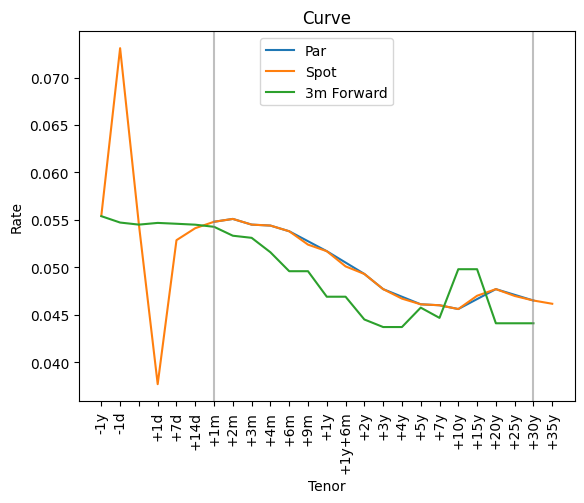

In [16]:
### CURVE GENERATION
# Curve Settings
curve_data =  {
    "1m":.0548,
     "2m":.0551,
     "3m":.0545,
     "4m":.0544,
     "6m":.0538,
     "1y":.0517,
     "2y":.0493,
     "3y":.0477,
     "5y":.0461,
     "7y":.0460,
     "10y":.0456,
     "20y":.0477,
     "30y":.0465
}
curve_settings = {
        'dc':"ACT/365", # only ACT/365 for now
        'cal':"ALL", # only ALL supported for now
        'method':"EXP", # 'EXP', 'YLD', 'LIN'
        'interp_on':"ln(df)", # 'ln(df)', 'r*t', or 'r'
        'interp_method':"linear", # see scipy for methods, 'linear', 'cubic' are common
        'extrap_method':'extrapolate', # 'flat' or 'extrapolate'
        'base':"t", # anchor date
}
curve = Curve(curve_data, **curve_settings)

### DATA GENERATION
# Data Settings
tenors_to_interpolate = ['-30y','-5y','-1y','-1d','0d','1d','1w','2w','1m','2m','3m','4m','6m','9m','1y','18m','2y','3y','4y','5y','7y','10y','15y','20y','25y','30y','35y','40y','50y']
tenors_to_interpolate = ['-1y','-1d','0d','1d','1w','2w','1m','2m','3m','4m','6m','9m','1y','18m','2y','3y','4y','5y','7y','10y','15y','20y','25y','30y','35y',]
# Forward distance for forward curve
forward_tenor = "3m"
par_data, spot_data, forward_data = generate_curve_data(curve, tenors_to_interpolate, forward_tenor)
plot_data = {"par":par_data,"spot":spot_data, "forward":forward_data}
# PLOT GENERATION
# Settings
plot_settings = {
'forward_tenor':forward_tenor,  # For labeling purposes
'style':'line', # 'line' or 'scatter'
'spacing':'equal', #'actual' or 'equal'
'y_axis':'rate', # 'rate' or 'df'
'x_axis':'tenor', # 'date' or 'tenor' or 'raw'
'to_plot':['par','spot','forward'] # choices are 'par', 'spot' and 'forward'
}
plot_curve(plot_data, **plot_settings)